## Were University Towns Less Affected by the Great Recession?

**Definitions**:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.
* _Chained GDP_ is adjusted to inflation, allowing us to compare accross time. 


**Hypothesis**: University towns have their mean housing prices less effected by recessions. I will run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The three data source I will use for this analysis are:

* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (using the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. I am only looking at GDP data from the first quarter of 2000 onward.


_This exercise is adapted from University of Michigan's Introduction to Data Science in Python_.


In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# dictionary of states and their acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [5]:
# load university towns list, GDP data, and Zillow housing data
univ_towns = pd.read_table('data/university_towns.txt', header=None, comment='(')
GDP_df = pd.read_excel('data/gdplev.xls',names=['Q','GDP'], parse_cols='E,G', skiprows=219)
housing_df = pd.read_csv('data/City_Zhvi_AllHomes.csv')

# rename column
univ_towns.columns = ['State']

# make a duplicate column and clean RegionName
univ_towns['RegionName'] = univ_towns.State
univ_towns['RegionName'] = univ_towns['RegionName'].str.rstrip()

# filter out values in State column that are not states
univ_towns['State'] = univ_towns['State'].where(univ_towns['State'].str.contains('\[edit\]'))

# fill out the rest of our State column and clean them up
univ_towns['State'].ffill(inplace=True)
clean_states = univ_towns['State'].str.replace('\[edit\]', '')
univ_towns['State'] = clean_states

# make a new clean DataFrame with State and RegionName
towns_df = univ_towns[~univ_towns.RegionName.str.contains('\[edit\]')]

# clean our Zillow housing data by swapping state abbreviation with full name
housing_df.State.replace(to_replace=states, inplace=True)
housing_df.set_index(['RegionName', 'State'], inplace=True)


In [92]:
# based on our definition, let's find the start of the recession

GDPlist = GDP_df.GDP.tolist()
index=0
for i, val in enumerate(GDPlist):
    if GDPlist[i+2] < GDPlist[i+1] < GDPlist[i]:
        index = i+1
        break
GDP_df['Q'].iloc[index]

'2008q3'

In [7]:
# that leads us to the recession end
recession_end = GDP_df['Q'].iloc[39]
recession_end

'2009q4'

In [24]:
# and our local min of the recession
recession_bottom = GDP_df['Q'].iloc[37]
recession_bottom


'2009q2'

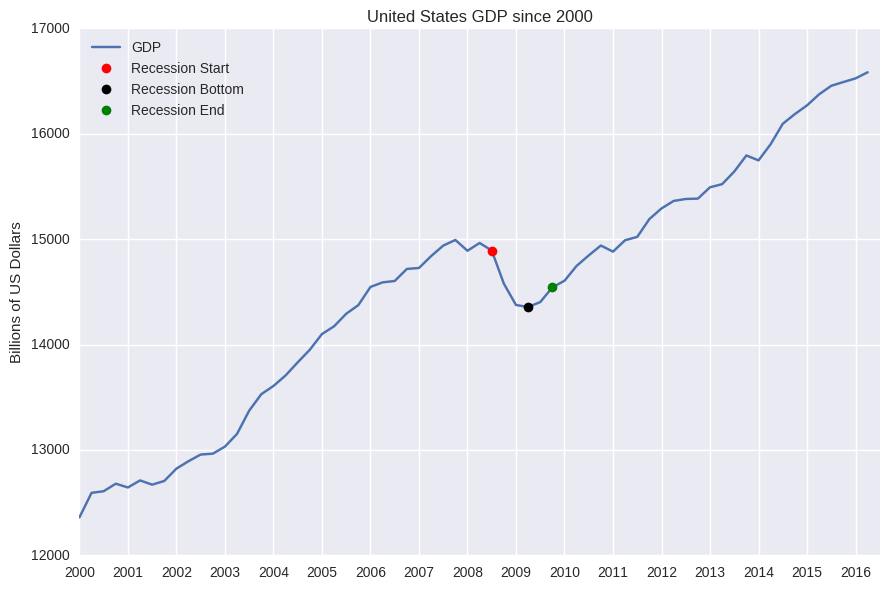

In [105]:
# let's visually verify the points identified
fig, ax = plt.subplots(figsize=(9,6))
x = np.arange(len(GDP_df))
x_names = list(GDP_df.Q.values)
y = GDP_df['GDP']
plt.plot(x,y)
ax.set_xticks(np.arange(0,66,4))
ax.set_xticklabels(np.arange(2000,2017))
ax.set_xlim([0,66])


plt.title('United States GDP since 2000')
plt.ylabel('Billions of US Dollars')
plt.tight_layout()

ax.plot(34, GDP_df['GDP'].loc[34], 'ro', label="Recession Start")
ax.plot(37, GDP_df['GDP'].loc[37], 'ko', label="Recession Bottom")
ax.plot(39, GDP_df['GDP'].loc[39], 'go', label="Recession End")
ax.legend(loc='best')

In [109]:
# grab the quarters column from GDP to eventually serve as column headers for our housing data
q_hdrs = GDP_df.Q.tolist()
q_hdrs.append('2016q3')

# filter out the unwanted months
cols = housing_df.columns[49:]
trim_housing_df = housing_df.loc[:,cols]

# resample columns for the quarterly mean
cnvrtd_hdrs = pd.to_datetime(trim_housing_df.columns, format='%Y-%m-%d')
trim_housing_df.columns = cnvrtd_hdrs
trim_housing_df_T = trim_housing_df.T.resample('Q').mean()
trim_housing_df = trim_housing_df_T.T

# finally replace our Datetime headers with our quarterly strings in the style of our GDP file
dt_hdrs = trim_housing_df.columns.tolist()
new_hdrs = list(zip(dt_hdrs,q_hdrs))
trim_housing_df.columns = pd.MultiIndex.from_tuples(new_hdrs)
q_index = trim_housing_df.columns.droplevel(0)
trim_housing_df.columns = q_index

trim_housing_df = trim_housing_df.swaplevel()

In [110]:
# make a copy of each
df_housing = trim_housing_df.copy()
df_towns = towns_df.copy()

# calculate the price ratio as specified in the hypothesis
df_housing['Price_Ratio'] = df_housing['2008q2']/df_housing['2009q2']


In [119]:
# merge DataFrames; the inner join will with df_towns ensures this DataFrame consists of only university towns
univ_housing = pd.merge(df_towns, df_housing, how='inner', left_on=['State','RegionName'],right_index=True)
univ_housing.set_index(['State','RegionName'],inplace=True)

# create a DataFrame of housing prices in non-university towns
non_univ_housing = df_housing[~df_housing.index.isin(univ_housing.index)]

univ_housing.shape, non_univ_housing.shape 

((269, 68), (10461, 68))

In [120]:
ttest_ind(univ_housing['Price_Ratio'].dropna().values, non_univ_housing['Price_Ratio'].dropna().values)


Ttest_indResult(statistic=-2.9980326641791835, pvalue=0.002724063704761164)

__With a p-value < 0.01, it looks like we do have a significant difference with the recession favoriing university towns__.